# Проект №3: Exploratory Data Analysis and Feature Engineering #

**Подробное описание постановки задачи, ссылки на Kaggle (Competition + Notebook) приведены в файле [README.md](README.md)**

In [74]:
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# Для корректной работы Jupyter Notebook
%matplotlib inline
# Для корректного отображения графиков в тёмной теме
plt.style.use('default')

DATA_PATH = 'data/'
# DATA_PATH = '/kaggle/input/sf-booking/'
OUTPUT_PATH = 'output/'
# OUTPUT_PATH = ''
RANDOM_STATE = 42

## 1. Сбор и предварительный анализ данных (Data Collection) ##

In [52]:
train_ini = pd.read_csv(DATA_PATH + 'hotels_train.csv')
test_ini = pd.read_csv(DATA_PATH + 'hotels_test.csv')
submission_df = pd.read_csv(DATA_PATH + 'submission.csv')

In [196]:
# Далее временно удобно работать с копиями датасетов
train_df = train_ini.copy()
test_df = test_ini.copy()

In [197]:
train_df.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [198]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [199]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

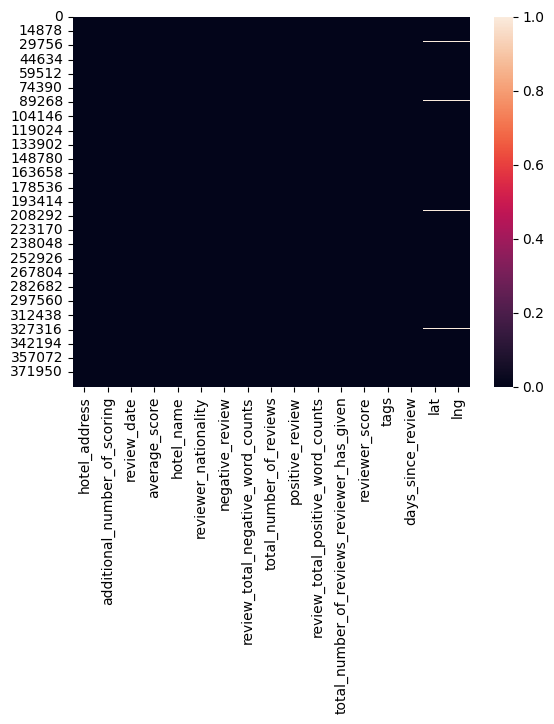

In [188]:
sns.heatmap(train_df.isnull());

In [200]:
print(f'TRAIN: empty lattitude sum: {train_df.lat.isna().sum()}')
print(f'TRAIN: empty longitude sum: {train_df.lng.isna().sum()}')
print(f'TEST: empty lattitude sum: {test_df.lat.isna().sum()}')
print(f'TEST: empty longitude sum: {test_df.lng.isna().sum()}')

TRAIN: empty lattitude sum: 2448
TRAIN: empty longitude sum: 2448
TEST: empty lattitude sum: 820
TEST: empty longitude sum: 820


Видно, что в обоих датасетах есть незаполненные координаты широты и долготы.

## 2. Создание признаков ##

### 2.1. One-hot кодирование признаков города из **`hotel_address`** и заполнение недостающих **`lat`** и **`lng`** среднегородскими значениями ###

In [201]:
for str_ in train_df.hotel_address[:10]:
    print(str_)

Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom
130 134 Southampton Row Camden London WC1B 5AF United Kingdom
151 bis Rue de Rennes 6th arr 75006 Paris France
216 Avenue Jean Jaures 19th arr 75019 Paris France
Molenwerf 1 1014 AG Amsterdam Netherlands
Via Mecenate 121 20138 Milan Italy
97 Cromwell Road Kensington and Chelsea London SW7 4DN United Kingdom
Josefsgasse 4 6 08 Josefstadt 1080 Vienna Austria
190 Queen s Gate Kensington and Chelsea London SW7 5EX United Kingdom
Holland Park Avenue Kensington and Chelsea London W11 4UL United Kingdom


In [202]:
countries = set()
cities = set()
for str_ in train_df.hotel_address:
    addr_ = str_.split()
    countries.add(addr_[-1])
    if addr_[-1] == 'Kingdom':
        cities.add(addr_[-5])
    else:
        cities.add(addr_[-2])
print(countries)
print(cities)

{'Kingdom', 'Netherlands', 'Austria', 'Italy', 'Spain', 'France'}
{'London', 'Vienna', 'Paris', 'Amsterdam', 'Milan', 'Barcelona'}


Выяснилось, что в обучающем и тестовом датасетах содержатся отели только из шести городов соответствующих шести стран. Тогда в обоих датасетах можно сделать следующее:

1. One-hot-кодирование дополнительных шести признаков по городам;
2. Удалить признак **`hotel_address`**;
3. Заполнить пустые ячейки в признаках **`lat`** и **`lng`** координатами центров соответствующих городов (взять из внешних источников).

In [203]:
def get_city(addr_str: str) -> str:
    ''' Находит в строке адреса название города
    Arguments:
        addr_str [str] -- Содержимое ячейки признака 'hotel_address'
    Returns:
        [str] -- Название города
    '''
    words_list = addr_str.split()
    if words_list[-1] == 'Kingdom':
        return words_list[-5]
    else:
        return words_list[-2]
    return 'Unknown'

# Создание временного признака города
train_df['city'] = train_df.hotel_address.apply(get_city)
test_df['city'] = test_df.hotel_address.apply(get_city)

# train_df = pd.get_dummies(train_df, columns=['city'])
# test_df = pd.get_dummies(test_df, columns=['city'])

In [204]:
# Координаты городов (lat, lng)
'''
city_coords = {
    'Amsterdam': (52.383333, 4.9),
    'Barcelona': (41.383333, 2.183333),
    'London': (51.507222, -0.1275),
    'Milan': (45.466667, 9.166667),
    'Paris': (48.833333, 2.333333),
    'Vienna': (48.216667, 16.373333)
}
for cityname, coords in city_coords.items():
    train_df[train_df.city == cityname]['lat'].fillna(coords[0], inplace=True)
    train_df[train_df.city == cityname]['lng'].fillna(coords[1])
    test_df[test_df.city == cityname]['lat'].fillna(coords[0])
    test_df[test_df.city == cityname]['lng'].fillna(coords[1])

print(f'TRAIN: empty lattitude sum: {train_df.lat.isna().sum()}')
print(f'TRAIN: empty longitude sum: {train_df.lng.isna().sum()}')
print(f'TEST: empty lattitude sum: {test_df.lat.isna().sum()}')
print(f'TEST: empty longitude sum: {test_df.lng.isna().sum()}')
'''

"\ncity_coords = {\n    'Amsterdam': (52.383333, 4.9),\n    'Barcelona': (41.383333, 2.183333),\n    'London': (51.507222, -0.1275),\n    'Milan': (45.466667, 9.166667),\n    'Paris': (48.833333, 2.333333),\n    'Vienna': (48.216667, 16.373333)\n}\nfor cityname, coords in city_coords.items():\n    train_df[train_df.city == cityname]['lat'].fillna(coords[0], inplace=True)\n    train_df[train_df.city == cityname]['lng'].fillna(coords[1])\n    test_df[test_df.city == cityname]['lat'].fillna(coords[0])\n    test_df[test_df.city == cityname]['lng'].fillna(coords[1])\n\nprint(f'TRAIN: empty lattitude sum: {train_df.lat.isna().sum()}')\nprint(f'TRAIN: empty longitude sum: {train_df.lng.isna().sum()}')\nprint(f'TEST: empty lattitude sum: {test_df.lat.isna().sum()}')\nprint(f'TEST: empty longitude sum: {test_df.lng.isna().sum()}')\n"

In [205]:
train_df = pd.get_dummies(train_df, columns=['city'])
test_df = pd.get_dummies(test_df, columns=['city'])

In [206]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 23 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

### 2.2. Извлечение из **`tags`** числа проведённых ночей и создание числового признака **`stayed_nights`** ###

In [207]:
def get_stayed_nights(tags_str: str) -> int:
    """ Разбивает строку признака 'tags' на отдельные тэги. Затем ищет
    тэг 'Stayed * nights' и возвращает число ночёвок. Если тэг не
    найден, возвращает 0.
    Arguments:
        tags_str [str] -- Содержимое ячейки признака 'tags'
    Returns:
        [int] -- Число проведённых в отеле ночей
    """
    tag_list = tags_str.lstrip('[').rstrip(']').split(', ')
    for tag in tag_list:
        tag = tag.lstrip("\' ").rstrip(" \'")
        words_list = tag.split()
        if words_list[0] == 'Stayed':
            return int(words_list[1])
    return 0

train_df['stayed_nights'] = train_df.tags.apply(get_stayed_nights)
test_df['stayed_nights'] = test_df.tags.apply(get_stayed_nights)

## 3. Преобразование признаков ##

### 3.1. Перевод в числовой вид признака **`days_since_review`** ###

In [208]:
for str_ in train_df.days_since_review[10:20]:
    print(str_)

288 day
450 day
164 day
399 day
165 day
290 day
89 days
29 days
513 day
678 day


In [209]:
train_df.days_since_review = train_df.days_since_review.apply(
                                lambda x: int(x.rstrip(' day').rstrip(' days')))
test_df.days_since_review = test_df.days_since_review.apply(
                                lambda x: int(x.rstrip(' day').rstrip(' days')))

In [210]:
train_df.review_date = pd.to_datetime(train_df.review_date)
test_df.review_date = pd.to_datetime(test_df.review_date)

## 4. Отбор признаков ##

<AxesSubplot: >

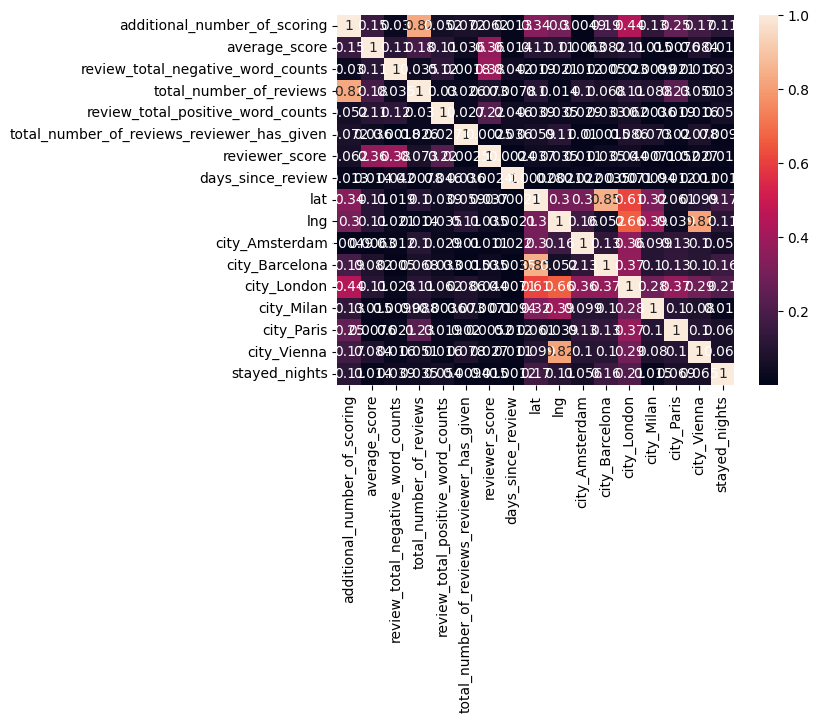

In [211]:
sns.heatmap(train_df.corr().abs(), annot=True)

In [212]:
train_df.total_number_of_reviews.describe()

count    386803.000000
mean       2743.992042
std        2316.457018
min          43.000000
25%        1161.000000
50%        2134.000000
75%        3613.000000
max       16670.000000
Name: total_number_of_reviews, dtype: float64

In [213]:
train_df.additional_number_of_scoring.describe()

count    386803.000000
mean        498.246536
std         500.258012
min           1.000000
25%         169.000000
50%         342.000000
75%         660.000000
max        2682.000000
Name: additional_number_of_scoring, dtype: float64

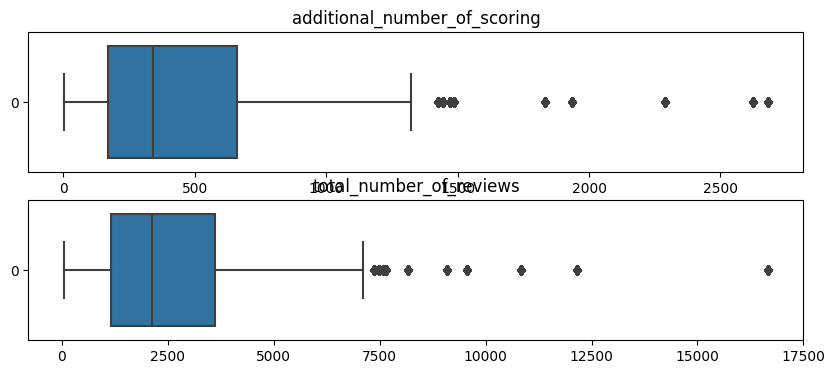

In [214]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 4))
sns.boxplot(
    data=train_df.additional_number_of_scoring,
    orient='h',
    ax=axes[0]
)
sns.boxplot(
    data=train_df.total_number_of_reviews,
    orient='h',
    ax=axes[1]
)
axes[0].set_title('additional_number_of_scoring')
axes[1].set_title('total_number_of_reviews');

In [215]:
drop_features_list = [
    'hotel_address',
    'review_date',
    'hotel_name',
    'reviewer_nationality',
    'negative_review',
    'positive_review',
    'tags',
    # 'total_number_of_reviews',
    # 'additional_number_of_scoring',
    # 'days_since_review',
    'lat',
    'lng'
]
train_df.drop(columns=drop_features_list, inplace=True)
test_df.drop(columns=drop_features_list, inplace=True)

## 5. Обучение модели ##

In [216]:
X = train_df.drop(columns=['reviewer_score'])
y = train_df.reviewer_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

In [217]:
regressor = RandomForestRegressor(
                                    n_estimators=100,
                                    # criterion='absolute_error',
                                    n_jobs=4,
                                    random_state=RANDOM_STATE
                                 )
regressor.fit(X_train, y_train)
y_predictor = regressor.predict(X_test)
print(f'MAPE:', metrics.mean_absolute_percentage_error(y_test, y_predictor))

MAPE: 0.1373969761063486


## 6. Формирование предсказаний ##

In [218]:
predictions = regressor.predict(test_df)
submission_df.reviewer_score = predictions
submission_df.head()

,reviewer_score,id
0,8.446,488440
1,7.060,274649
2,8.374,374688
3,9.527,404352
4,9.826,451596


In [219]:
submission_df.shape

(128935, 2)

In [220]:
submission_df.to_csv(OUTPUT_PATH + 'submission.csv', index=False)